In [84]:
## TensorFlow 
import tensorflow as tf

## "Normal" libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import (auc, precision_recall_curve, confusion_matrix,
                             roc_auc_score, roc_curve, classification_report,
                             precision_score, recall_score, f1_score, accuracy_score,
                             roc_curve, auc)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
from IPython.display import SVG
from sklearn.linear_model import LogisticRegression

In [85]:
def unique_value_counts(array):
    array = np.array(array)  # Convert to numpy array if not already
    unique, counts = np.unique(array, return_counts=True)
    return dict(zip(unique, counts))

In [86]:
def calculate_metrics(y_true, y_pred, y_prob=None, metrics=['precision', 'recall', 'f1', 'accuracy', 'auc']):
    # Compute the confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    TP = cm[1, 1]
    FP = cm[0, 1]
    TN = cm[0, 0]
    FN = cm[1, 0]

    results = {}

    # Calculate precision
    if 'precision' in metrics:
        results['precision'] = round( TP / (TP + FP), 4) if (TP + FP) > 0 else 0

    # Calculate recall
    if 'recall' in metrics:
        results['recall'] = round( TP / (TP + FN), 4) if (TP + FN) > 0 else 0

    # Calculate F1 score
    if 'f1' in metrics:
        results['f1'] = round( 2 * (TP / (2 * TP + FP + FN)), 4) if (2 * TP + FP + FN) > 0 else 0

    # Calculate accuracy
    if 'accuracy' in metrics:
        results['accuracy'] = round( (TP + TN) / (TP + TN + FP + FN), 4)

    # Calculate AUC
    if 'auc' in metrics and y_prob is not None:
        # Note: AUC requires probabilities, not class labels.
        results['auc'] = round( roc_auc_score(y_true, y_prob), 4)

    return results


# Data set-up

In [87]:
# Load the dataset
data = pd.read_excel('cleaned data.xlsx')

# Save as dataframe
data = pd.DataFrame(data)

In [88]:
# create X (features) and y (response)
X = data.drop(['Pno', 'Take-up ind'], axis = 1)
y = data['Take-up ind']

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Fit and transform the data
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# all my variables as seen as floats rather than strings or integers
X = X.astype(np.float32).values
y = y.astype(np.float32).values

In [89]:
# Get the test set (10%)
x_train_val, x_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.1, stratify=y, random_state=7)

# Now training (70%) and validation sets (20%)
x_train, x_val, y_train, y_val = train_test_split(
    x_train_val, y_train_val, test_size=0.2222, stratify=y_train_val, random_state=7)

# Apply SMOTE to the training data
smote = SMOTE(random_state=7)
x_train_smote, y_train_smote = smote.fit_resample(x_train, y_train)

# Version 1 - NO SMOTE

In [90]:
logreg = LogisticRegression(max_iter=2000, random_state=7, solver='lbfgs', C=1.0, penalty='l2') # start with many iterations and no penalty

# Fit and save the logistic regression model using the training data
model = logreg.fit(x_train, y_train)

In [91]:
# Predict
y_probs = model.predict(x_val)
y_val_pred = (y_probs > 0.5).astype(int) # Apply threshold
print(unique_value_counts(y_val_pred))

# Metrics
metrics = calculate_metrics(y_true=y_val, y_pred=y_val_pred, y_prob=y_probs,
                            metrics=['precision', 'recall', 'f1', 'accuracy', 'auc'])
print(metrics) 


{0: 214, 1: 5}
{'precision': 0.8, 'recall': 0.1905, 'f1': 0.3077, 'accuracy': 0.9178, 'auc': 0.5927}


# Version 2 - SMOTE

In [92]:
logreg = LogisticRegression(max_iter=2000, random_state=7, solver='lbfgs', C=1.0, penalty='l2')

# Fit and save the logistic regression model using the training data
model = logreg.fit(x_train_smote, y_train_smote)

In [93]:
# Predict
y_probs = model.predict(x_val)
y_val_pred = (y_probs > 0.5).astype(int) # Apply threshold
print(unique_value_counts(y_val_pred))

# Metrics
metrics = calculate_metrics(y_true=y_val, y_pred=y_val_pred, y_prob=y_probs,
                            metrics=['precision', 'recall', 'f1', 'accuracy', 'auc'])
print(metrics)

{0: 176, 1: 43}
{'precision': 0.2093, 'recall': 0.4286, 'f1': 0.2812, 'accuracy': 0.79, 'auc': 0.6284}


# Version 3 - SMOTE, NOW L1

In [94]:
logreg = LogisticRegression(max_iter=2000, random_state=7, solver='liblinear', C=1.0, penalty='l1')

# Fit and save the logistic regression model using the training data
model = logreg.fit(x_train_smote, y_train_smote)

In [95]:
# Predict
y_probs = model.predict(x_val)
y_val_pred = (y_probs > 0.5).astype(int) # Apply threshold
print(unique_value_counts(y_val_pred))

# Metrics
metrics = calculate_metrics(y_true=y_val, y_pred=y_val_pred, y_prob=y_probs,
                            metrics=['precision', 'recall', 'f1', 'accuracy', 'auc'])
print(metrics)

{0: 177, 1: 42}
{'precision': 0.2381, 'recall': 0.4762, 'f1': 0.3175, 'accuracy': 0.8037, 'auc': 0.6573}


# HYPERPARAMETER TUNING

In [121]:
# Determine a hyperparameter grid
parameter_grid = {
    'lambda_val': [0.001, 0.01, 0.1, 0.5, 1, 2, 5, 10],
    'penalty': ['l1', 'l2'], # both regularizations
    'solver': ['liblinear'],  # check guides online!
    'max_iter': [50, 100, 150, 200, 300]
}

In [122]:
# Initialize
best_auc = -np.inf # start at the lowest possible
best_parameters = None
best_model = None

In [123]:
# Iterate the model over the parameters

for lambda_val in parameter_grid['lambda_val']:

    for penalty in parameter_grid['penalty']:

        for solver in parameter_grid['solver']:

            for max_iter in parameter_grid['max_iter']:

                # run model like before
                model = LogisticRegression(C=lambda_val, penalty=penalty, solver=solver, max_iter=max_iter)
                model.fit(x_train, y_train)
                # predict like before

                # Predict
                y_probs = model.predict(x_val)
                y_val_pred = (y_probs > 0.5).astype(int) # Apply threshold
                
                # Metrics
                metrics = calculate_metrics(y_true=y_val, y_pred=y_val_pred, y_prob=y_probs,
                            metrics=['precision', 'recall', 'f1', 'accuracy', 'auc'])

                #print(metrics) # see as iterations continue

                # AUC specifically
                new_auc = roc_auc_score(y_val, y_probs)
                
                if new_auc > best_auc:
                    best_auc = new_auc
                    best_parameters = {'lambda_val': lambda_val, 'penalty': penalty, 'solver': solver, 'max_iter': max_iter}
                    best_model = model


In [124]:
print(f"Best parameters: {best_parameters}")
print(f"Best AUC on thr validation set: {round(best_auc, 4)}")
best_model

Best parameters: {'lambda_val': 0.5, 'penalty': 'l1', 'solver': 'liblinear', 'max_iter': 50}
Best AUC on thr validation set: 0.5927


LogisticRegression(C=0.5, max_iter=50, penalty='l1', solver='liblinear')

# Rebuild the best tuned and chosen model

In [125]:
logreg = LogisticRegression(max_iter=50, random_state=7, solver='liblinear', C=0.5, penalty='l1')

# Fit and save the logistic regression model using the training data
model = logreg.fit(x_train_smote, y_train_smote)

In [126]:
# Predict
y_probs = model.predict(x_val)
y_val_pred = (y_probs > 0.5).astype(int) # Apply threshold
print(unique_value_counts(y_val_pred))

# Metrics
metrics = calculate_metrics(y_true=y_val, y_pred=y_val_pred, y_prob=y_probs,
                            metrics=['precision', 'recall', 'f1', 'accuracy', 'auc'])
print(metrics)

{0: 177, 1: 42}
{'precision': 0.2143, 'recall': 0.4286, 'f1': 0.2857, 'accuracy': 0.7945, 'auc': 0.631}


In [127]:
# Predict
y_probs = model.predict(x_test)
y_test_pred = (y_probs > 0.5).astype(int) # Apply threshold
print(unique_value_counts(y_test_pred))

# Metrics
metrics = calculate_metrics(y_true=y_test, y_pred=y_test_pred, y_prob=y_probs,
                            metrics=['precision', 'recall', 'f1', 'accuracy', 'auc'])
print(metrics)

{0: 70, 1: 40}
{'precision': 0.15, 'recall': 0.6, 'f1': 0.24, 'accuracy': 0.6545, 'auc': 0.63}


In [128]:
cm_df = pd.DataFrame(confusion_matrix(y_test_pred, y_test), 
                     index=['Actual 0', 'Actual 1'], 
                     columns=['Predicted 0', 'Predicted 1'])
cm_df

,Predicted 0,Predicted 1
Actual 0,66,4
Actual 1,34,6


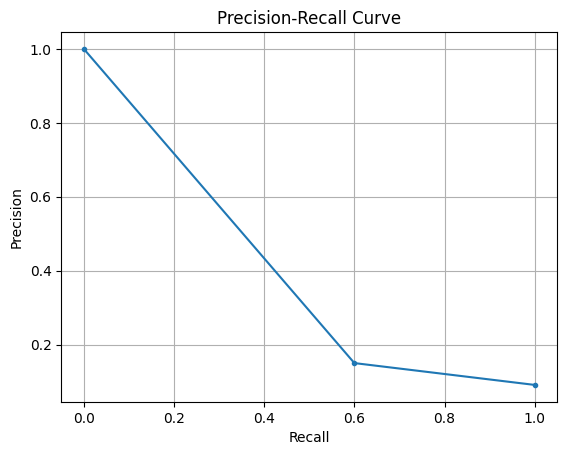

In [129]:
# Compute precision and recall values
precision, recall, thresholds = precision_recall_curve(y_test, y_probs)

# Plot the Precision-Recall curve
plt.figure()
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.show()

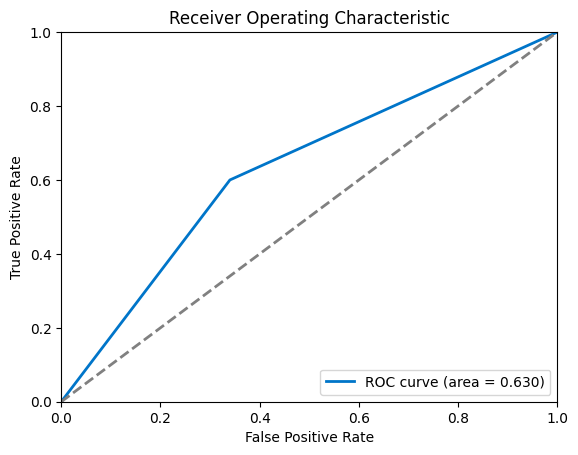

In [138]:
# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test, y_test_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='#0075C9', lw=2, label=f'ROC curve (area = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()